In [1]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime
from glob import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
COUNTRIES_KEYWORDS = {
    "IT": ["auto", "taxi", "bicicletta", "autobus", "telelavoro",
    "supermercato vicino", "ristorante vicino", "acquisti online",
    "auto elettrica", "colonnina di ricarica", "consumo benzina", "auto ibrida"],
    "FR": [
        "voiture", "taxi", "vélo", "autobus",
        "télétravail", "supermarché proche", "restaurant proche", "achat en ligne",
        "voiture électrique", "borne de recharge", "consommation essence", "voiture hybride"
    ],
    "DE": ["auto", "taxi", "fahrrad", "bus", "homeoffice", "supermarkt in der nähe",
         "restaurant in der nähe", "online einkaufen", "elektroauto",
         "elektroauto aufladen", "benzinverbrauch", "hybridauto"],
    "US": [
        "car", "taxi", "bike", "bus",
        "work from home", "grocery store near me", "restaurant near me", "online shopping",
        "electric car", "charging station", "gas consumption", "hybrid car"
    ],
    "GB": [
        "car", "taxi", "bicycle", "bus",
        "work from home", "supermarket near me", "restaurant near me", "online shopping",
        "electric car", "charging point", "petrol consumption", "hybrid car"
    ],

    "ES": [
        "coche", "taxi", "bicicleta", "autobús",
        "teletrabajo", "supermercado cerca", "restaurante cerca", "compra online",
        "coche eléctrico", "electrolinera", "consumo gasolina", "coche híbrido"
    ],
    "PT": [
        "carro", "táxi", "bicicleta", "autocarro",
        "trabalho remoto", "supermercado perto", "restaurante perto", "compras online",
        "carro elétrico", "posto de carregamento", "consumo gasolina", "carro híbrido"
    ],
    }

In [3]:

BASE_FOLDER = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_2\x"

# --- Equivalencias comunes ---
COMMON_KEYWORDS = {
    "bicicleta": "bike", "bicycle": "bike", "vélo": "bike", "bicicletta": "bike","fahrrad": "bike",
    "coche": "car", "car": "car", "auto": "car", "voiture": "car", "carro": "car",
    "autobús": "bus", "bus": "bus", "autocarro": "bus", "autobus": "bus",
    "teletrabajo": "remote_work", "work from home": "remote_work", "trabalho remoto": "remote_work", "télétravail": "remote_work", "homeoffice": "remote_work", "telelavoro": "remote_work",
    "supermercado cerca": "supermarket", "supermarket near me": "supermarket", "supermarché proche": "supermarket", "supermercado perto": "supermarket", "supermarkt in der nähe": "supermarket", "supermercato vicino": "supermarket", "grocery store near me": "supermarket",	
    "restaurante cerca": "restaurant", "restaurant near me": "restaurant", "restaurant proche": "restaurant", "restaurante perto": "restaurant", "restaurant in der nähe": "restaurant", "ristorante vicino": "restaurant",
    "compra online": "online_shopping", "online shopping": "online_shopping", "compras online": "online_shopping", "achat en ligne": "online_shopping", "online einkaufen": "online_shopping", "acquisti online": "online_shopping",
    "coche eléctrico": "electric_car", "electric car": "electric_car", "voiture électrique": "electric_car", "auto elettrica": "electric_car", "carro elétrico": "electric_car", "elektroauto": "electric_car",
    "electrolinera": "charging_station", "charging station": "charging_station", "borne de recharge": "charging_station", "posto de carregamento": "charging_station", "charging point": "charging_station", "colonnina di ricarica": "charging_station", "elektroauto aufladen": "charging_station",
    "consumo gasolina": "fuel_consumption", "gas consumption": "fuel_consumption", "consommation essence": "fuel_consumption", "consumo benzina": "fuel_consumption", "petrol consumption": "fuel_consumption", "benzinverbrauch": "fuel_consumption",
    "coche híbrido": "hybrid_car", "hybrid car": "hybrid_car", "voiture hybride": "hybrid_car", "auto ibrida": "hybrid_car", "carro híbrido": "hybrid_car", "hybridauto": "hybrid_car",
    "taxi": "taxi", "táxi": "taxi",
}

# --- Funciones base ---

def rename_value_column(df):
    if "time [UTC]" in df.columns:
        df = df.rename(columns={"time [UTC]": "date"})
    for c in df.columns:
        if c not in ["date", "keywords", "keyword", "country", "muestra_n", "timestamp", "value"]:
            df = df.rename(columns={c: "value"})
            break
    return df

def load_trend_data(base_folder, country, keyword, control_term="wikipedia"):
    def build_path(kw):
        filename = f"x_{country}_{kw.replace(' ', '_')}.csv"
        return os.path.join(base_folder, filename)

    df_x = rename_value_column(pd.read_csv(build_path(keyword)))
    df_comb = rename_value_column(pd.read_csv(build_path(f"{keyword} + {control_term}")))
    df_ctrl = rename_value_column(pd.read_csv(build_path(control_term)))

    return df_x, df_comb, df_ctrl

def get_common_samples(df_x, df_comb, df_ctrl):
    samples_x = set(df_x["muestra_n"])
    samples_comb = set(df_comb["muestra_n"])
    samples_ctrl = set(df_ctrl["muestra_n"])
    return sorted(samples_x & samples_comb & samples_ctrl)

def clean_sample(df, sample_n, value_col="value"):
    df_ = df[df["muestra_n"] == sample_n].copy()
    df_ = df_[~df_[value_col].isin([0, 100])]
    return df_

def imputar_muestra(df_x, df_comb, df_ctrl, sample_n):
    dx = clean_sample(df_x, sample_n)
    dcomb = clean_sample(df_comb, sample_n)
    dctrl = clean_sample(df_ctrl, sample_n)

    df = dx[["date", "value"]].rename(columns={"value": "x"}).copy()
    df = df.merge(dcomb[["date", "value"]].rename(columns={"value": "combined"}), on="date", how="inner")
    df = df.merge(dctrl[["date", "value"]].rename(columns={"value": "control"}), on="date", how="inner")

    if len(df) < 3:
        return None

    X = df[["combined", "control"]]
    y = df["x"]
    model = LinearRegression().fit(X, y)
    df["imputed"] = model.predict(X)
    return df[["date", "imputed"]]

def construir_serie_normalizada_con_imputaciones(base_folder, country, keyword):
    df_x, df_comb, df_ctrl = load_trend_data(base_folder, country, keyword)
    muestras_validas = get_common_samples(df_x, df_comb, df_ctrl)

    imputaciones = []
    for m in muestras_validas:
        df_imp = imputar_muestra(df_x, df_comb, df_ctrl, m)
        if df_imp is not None:
            df_imp["sample_n"] = m
            imputaciones.append(df_imp)

    if not imputaciones:
        return None

    df_all = pd.concat(imputaciones, ignore_index=True)
    df_all["date"] = pd.to_datetime(df_all["date"], format='mixed', errors='coerce')
    df_wide = df_all.pivot(index="date", columns="sample_n", values="imputed")
    df_wide["mean_imputed"] = df_wide.mean(axis=1)

    serie = df_wide["mean_imputed"]
    z = (serie - serie.mean()) / serie.std()

    keyword_common = COMMON_KEYWORDS.get(keyword.lower(), keyword.lower())

    df_z = pd.DataFrame({
        "date": serie.index,
        "keyword": keyword,
        "keyword_common": keyword_common,
        "country": country,
        "imputed": serie.values,
        "zscore": z.values
    }).reset_index(drop=True)

    return df_z

def construir_panel_global(base_folder, country_keywords):
    panel = []
    for country, keywords in country_keywords.items():
        print(f"\n📦 Procesando país: {country}")
        for keyword in keywords:
            print(f"  🔍 Keyword: {keyword}")
            try:
                df_z = construir_serie_normalizada_con_imputaciones(base_folder, country, keyword)
                if df_z is not None:
                    panel.append(df_z)
            except Exception as e:
                print(f"  ⚠️ Error con '{keyword}' en {country}: {e}")
    if panel:
        return pd.concat(panel, ignore_index=True)
    else:
        return None
# --- EJECUTAR PANEL ---
df_panel = construir_panel_global(BASE_FOLDER, COUNTRIES_KEYWORDS)

if df_panel is not None:
    print("✅ Panel generado con éxito. Muestras:", df_panel.shape)


📦 Procesando país: IT
  🔍 Keyword: auto
  ⚠️ Error con 'auto' en IT: [Errno 2] No such file or directory: 'C:\\Users\\34645\\Desktop\\projects\\GoogleTrends\\Data\\raw_2\\x\\x_IT_auto_+_wikipedia.csv'
  🔍 Keyword: taxi
  🔍 Keyword: bicicletta
  🔍 Keyword: autobus
  🔍 Keyword: telelavoro
  🔍 Keyword: supermercato vicino
  🔍 Keyword: ristorante vicino
  🔍 Keyword: acquisti online
  🔍 Keyword: auto elettrica
  🔍 Keyword: colonnina di ricarica
  🔍 Keyword: consumo benzina
  🔍 Keyword: auto ibrida
  ⚠️ Error con 'auto ibrida' en IT: [Errno 2] No such file or directory: 'C:\\Users\\34645\\Desktop\\projects\\GoogleTrends\\Data\\raw_2\\x\\x_IT_auto_ibrida_+_wikipedia.csv'

📦 Procesando país: FR
  🔍 Keyword: voiture
  🔍 Keyword: taxi
  🔍 Keyword: vélo
  🔍 Keyword: autobus
  🔍 Keyword: télétravail
  🔍 Keyword: supermarché proche
  🔍 Keyword: restaurant proche
  🔍 Keyword: achat en ligne
  🔍 Keyword: voiture électrique
  🔍 Keyword: borne de recharge
  🔍 Keyword: consommation essence
  🔍 Keyword:

In [4]:
def revisar_keywords_it(base_folder, keywords, country="IT"):
    for kw in keywords:
        files = [
            f"x_{country}_{kw.replace(' ', '_')}.csv",
            f"x_{country}_{kw.replace(' ', '_')}_+_wikipedia.csv",
            f"x_{country}_wikipedia.csv"
        ]
        print(f"🔍 Keyword: {kw}")
        for file in files:
            path = os.path.join(base_folder, file)
            exists = os.path.exists(path)
            print(f"   - {'✅' if exists else '❌'} {file}")

# Lista original de keywords de IT
keywords_it = [
    "auto", "taxi", "bicicletta", "autobus", "telelavoro",
    "supermercato vicino", "ristorante vicino", "acquisti online",
    "auto elettrica", "colonnina di ricarica", "consumo benzina", "auto ibrida"
]

# Cambia esto a tu ruta de datos reales
carpeta_datos = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_2\x"

revisar_keywords_it(carpeta_datos, keywords_it)


🔍 Keyword: auto
   - ✅ x_IT_auto.csv
   - ❌ x_IT_auto_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: taxi
   - ✅ x_IT_taxi.csv
   - ✅ x_IT_taxi_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: bicicletta
   - ✅ x_IT_bicicletta.csv
   - ✅ x_IT_bicicletta_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: autobus
   - ✅ x_IT_autobus.csv
   - ✅ x_IT_autobus_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: telelavoro
   - ✅ x_IT_telelavoro.csv
   - ✅ x_IT_telelavoro_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: supermercato vicino
   - ✅ x_IT_supermercato_vicino.csv
   - ✅ x_IT_supermercato_vicino_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: ristorante vicino
   - ✅ x_IT_ristorante_vicino.csv
   - ✅ x_IT_ristorante_vicino_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: acquisti online
   - ✅ x_IT_acquisti_online.csv
   - ✅ x_IT_acquisti_online_+_wikipedia.csv
   - ✅ x_IT_wikipedia.csv
🔍 Keyword: auto elettrica
   - ✅ x_IT_auto_elettrica.csv
   - ✅ x_IT_a

In [5]:
df_panel

,date,keyword,keyword_common,country,imputed,zscore
0,2018-01-01,taxi,taxi,IT,45.146895,-0.527706
1,2018-02-01,taxi,taxi,IT,32.615882,-1.367146
2,2018-03-01,taxi,taxi,IT,50.112674,-0.195053
3,2018-04-01,taxi,taxi,IT,54.031010,0.067432
4,2018-06-01,taxi,taxi,IT,56.172523,0.210890
...,...,...,...,...,...,...
6779,2024-09-01,carro híbrido,hybrid_car,PT,66.900487,1.481102
6780,2024-10-01,carro híbrido,hybrid_car,PT,67.135632,1.506014
6781,2024-11-01,carro híbrido,hybrid_car,PT,67.624961,1.557854
6782,2024-12-01,carro híbrido,hybrid_car,PT,66.361924,1.424045


In [6]:
def verificar_keywords_por_pais(df_panel):
    conteo = df_panel.groupby("country")["keyword_common"].nunique().sort_values()
    print("🔎 Número de keywords comunes por país:\n")
    print(conteo)
    return conteo

In [7]:
verificar_keywords_por_pais(df_panel)


🔎 Número de keywords comunes por país:

country
IT    10
DE    12
ES    12
FR    12
GB    12
PT    12
US    12
Name: keyword_common, dtype: int64


country
IT    10
DE    12
ES    12
FR    12
GB    12
PT    12
US    12
Name: keyword_common, dtype: int64

In [8]:
def filtrar_keywords_comunes(df_panel):
    # Paso 1: obtener cuántos países hay
    total_paises = df_panel["country"].nunique()

    # Paso 2: contar en cuántos países aparece cada keyword_common
    cobertura = df_panel.groupby("keyword_common")["country"].nunique()

    # Paso 3: seleccionar solo las que aparecen en todos los países
    keywords_validas = cobertura[cobertura == total_paises].index.tolist()

    # Paso 4: filtrar el panel
    df_filtrado = df_panel[df_panel["keyword_common"].isin(keywords_validas)].copy()

    return df_filtrado, keywords_validas

In [9]:
df_panel_filtrado, keywords_comunes_usadas = filtrar_keywords_comunes(df_panel)

print("✅ Keywords comunes retenidas:", keywords_comunes_usadas)

✅ Keywords comunes retenidas: ['bike', 'bus', 'charging_station', 'electric_car', 'fuel_consumption', 'online_shopping', 'remote_work', 'restaurant', 'supermarket', 'taxi']


📈 Varianza explicada por componente:
PC1: 32.560% (λ = 3.59)
PC2: 17.706% (λ = 1.95)
PC3: 13.136% (λ = 1.45)
PC4: 9.944% (λ = 1.10)
PC5: 6.823% (λ = 0.75)
PC6: 6.036% (λ = 0.67)
PC7: 4.762% (λ = 0.52)
PC8: 3.288% (λ = 0.36)
PC9: 2.684% (λ = 0.30)
PC10: 1.825% (λ = 0.20)
PC11: 1.235% (λ = 0.14)

✅ Componentes con λ > 1 (Regla de Kaiser): 4


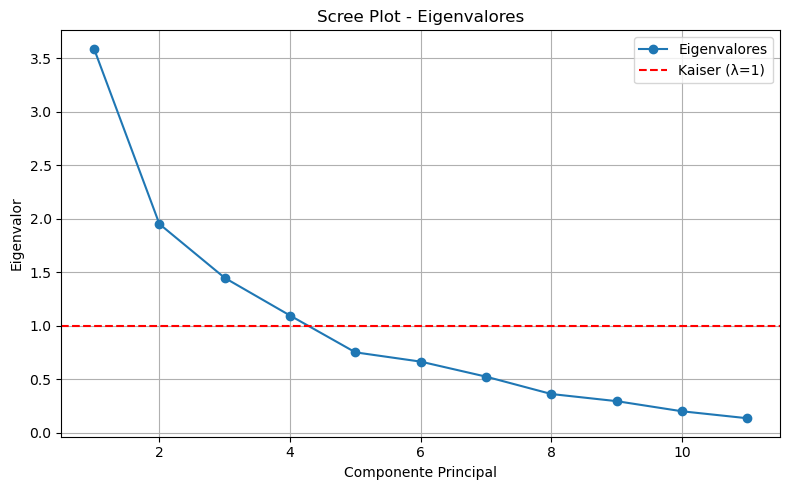


📊 Primeras filas de los scores:
        date country       PC1       PC2       PC3       PC4       PC5  \
0 2018-01-01      DE  1.651783  0.888039  3.684038 -1.865468  1.293106   
1 2018-01-01      FR  2.594522 -2.049702  0.292718 -2.025088  1.610601   
2 2018-01-01      GB  3.072799 -2.146454  0.642934  1.087963 -1.002964   
3 2018-01-01      IT  1.989908 -1.130254 -3.604594 -1.757244  1.588729   
4 2018-01-01      PT  4.197624  0.893089  2.080600 -0.730334 -0.886930   

        PC6       PC7       PC8       PC9      PC10      PC11  
0  0.188434 -0.026081 -0.450136  0.596079 -0.101335  0.032731  
1  1.025821  0.266974 -0.759622 -0.479895 -0.552331 -0.072692  
2 -0.527591  1.603483 -0.164976  0.608820  0.136746 -0.599337  
3 -0.244108 -0.022233 -0.470419  0.701360 -0.684203  0.323674  
4 -1.233172  0.064701 -1.117117 -0.742431 -0.382206  0.582199  

🔍 Cargas (loadings):
keyword_common      bike       bus       car  electric_car  fuel_consumption  \
PC1            -0.087094 -0.162186 -

In [10]:

# ---------------------
# 1. Preparar el panel
# ---------------------
def preparar_panel_para_pca(df_panel, eliminar_columnas=None, metodo_imputacion="media"):
    df_pivot = df_panel.pivot_table(
        index=["date", "country"],
        columns="keyword_common",
        values="zscore"
    ).reset_index()

    if eliminar_columnas:
        df_pivot = df_pivot.drop(columns=eliminar_columnas, errors="ignore")

    if metodo_imputacion == "media":
        df_pivot_imputado = df_pivot.fillna(df_pivot.mean(numeric_only=True))
    elif metodo_imputacion == "mediana":
        df_pivot_imputado = df_pivot.fillna(df_pivot.median(numeric_only=True))
    else:
        raise ValueError("Método de imputación no reconocido")

    return df_pivot_imputado

# ---------------------
# 2. Aplicar PCA
# ---------------------
def aplicar_pca(df_pivot, n_components=None):
    df_index = df_pivot[["date", "country"]]
    df_vars = df_pivot.drop(columns=["date", "country"])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_vars)

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_scaled)

    df_scores = pd.DataFrame(components, columns=[f"PC{i+1}" for i in range(components.shape[1])])
    df_scores = pd.concat([df_index.reset_index(drop=True), df_scores], axis=1)

    df_loadings = pd.DataFrame(
        pca.components_, 
        columns=df_vars.columns, 
        index=[f"PC{i+1}" for i in range(pca.n_components_)]
    )

    var_exp = pca.explained_variance_ratio_
    eigenvalues = pca.explained_variance_

    return df_scores, df_loadings, var_exp, eigenvalues

# ---------------------
# 3. Regla de Kaiser + Scree Plot
# ---------------------
def analizar_componentes(eigenvalues, var_exp):
    print("📈 Varianza explicada por componente:")
    for i, v in enumerate(var_exp):
        print(f"PC{i+1}: {v:.3%} (λ = {eigenvalues[i]:.2f})")

    kaiser_count = np.sum(eigenvalues > 1)
    print(f"\n✅ Componentes con λ > 1 (Regla de Kaiser): {kaiser_count}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', label="Eigenvalores")
    plt.axhline(y=1, color="red", linestyle="--", label="Kaiser (λ=1)")
    plt.title("Scree Plot - Eigenvalores")
    plt.xlabel("Componente Principal")
    plt.ylabel("Eigenvalor")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------
# 4. EJECUTAR TODO
# ---------------------
# Tus datos originales: df_panel
# Preparar el panel
df_pivot_pca = preparar_panel_para_pca(
    df_panel,
    eliminar_columnas=["charging_station"],  # quita variables si hace falta
    metodo_imputacion="media"                # o "mediana"
)

# Aplicar PCA
df_scores, df_loadings, var_exp, eigenvalues = aplicar_pca(df_pivot_pca)

# Analizar varianza
analizar_componentes(eigenvalues, var_exp)

# Mostrar resultados (opcionales)
print("\n📊 Primeras filas de los scores:")
print(df_scores.head())

print("\n🔍 Cargas (loadings):")
print(df_loadings)

In [11]:
def construir_indice_sostenible(df_scores, var_exp, eigenvalues):
    """
    Construye un índice de movilidad sostenible a partir de los componentes con λ > 1,
    ponderados por su varianza explicada.
    """
    # 1. Seleccionar componentes válidas (λ > 1)
    indices_kaiser = np.where(eigenvalues > 1)[0]
    pcs_validas = [f"PC{i+1}" for i in indices_kaiser]

    if not pcs_validas:
        raise ValueError("No hay componentes con eigenvalor > 1 (Kaiser)")

    # 2. Ponderaciones normalizadas
    pesos = var_exp[indices_kaiser]
    pesos_normalizados = pesos / pesos.sum()

    # 3. Calcular índice ponderado
    matriz_componentes = df_scores[pcs_validas].values
    indice = np.dot(matriz_componentes, pesos_normalizados)

    df_indice = df_scores[["date", "country"]].copy()
    df_indice["movilidad_sostenible"] = indice

    # 4. Normalizar (Z-score global)
    z = (df_indice["movilidad_sostenible"] - df_indice["movilidad_sostenible"].mean()) / df_indice["movilidad_sostenible"].std()
    df_indice["indice_normalizado"] = z

    return df_indice


In [12]:
df_indice = construir_indice_sostenible(df_scores, var_exp, eigenvalues)

print("📊 Índice de movilidad sostenible por país y fecha:")
print(df_indice.head())

📊 Índice de movilidad sostenible por país y fecha:
        date country  movilidad_sostenible  indice_normalizado
0 2018-01-01      DE              1.354521            1.437988
1 2018-01-01      FR              0.434826            0.461620
2 2018-01-01      GB              1.108565            1.176877
3 2018-01-01      IT             -0.273292           -0.290132
4 2018-01-01      PT              2.352625            2.497597


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_indice_por_pais(df_indice, columna="indice_normalizado"):
    """
    Grafica la serie temporal del índice de movilidad sostenible por país.
    
    Parámetros:
        df_indice: DataFrame con columnas 'date', 'country' y el índice.
        columna: Nombre de la columna a graficar (por defecto, índice normalizado).
    """
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_indice, x="date", y=columna, hue="country", marker="o")
    
    plt.title("📈 Índice de Movilidad Sostenible (Z-score) por País")
    plt.xlabel("Fecha")
    plt.ylabel("Índice Normalizado")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title="País", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()


C:\Users\34645\AppData\Local\Temp\ipykernel_4176\1769368297.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\34645\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


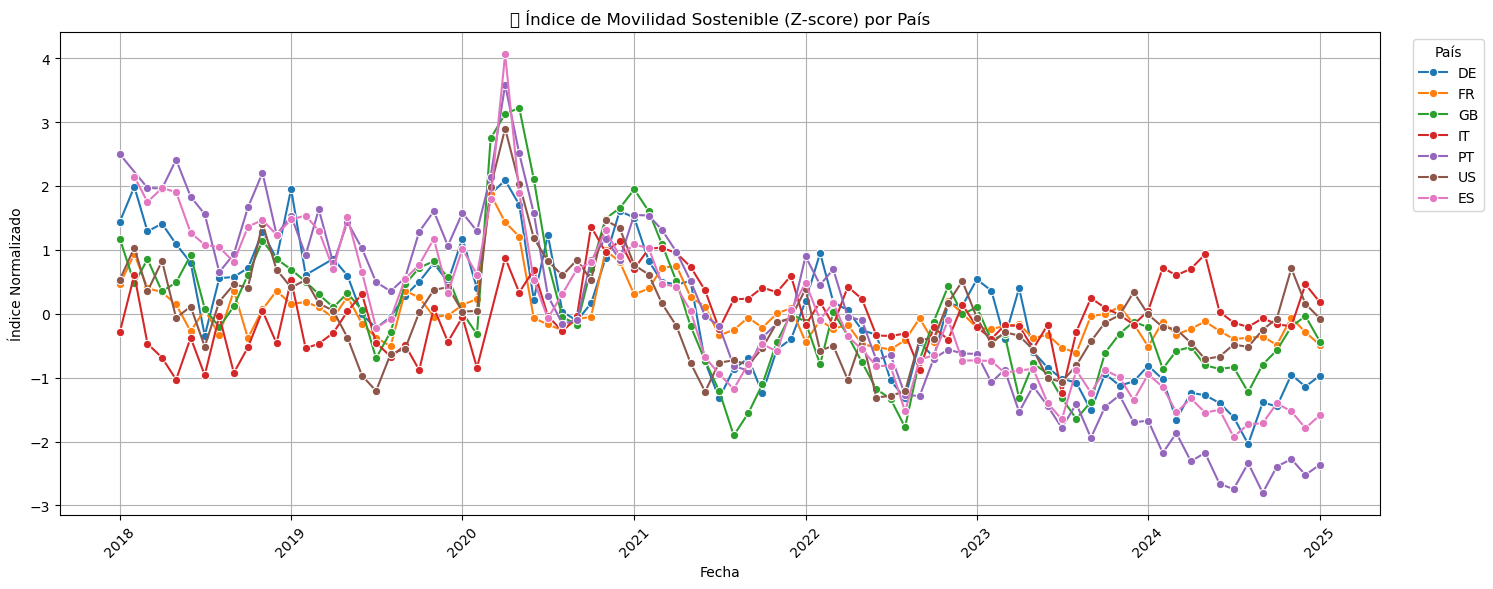

In [14]:
graficar_indice_por_pais(df_indice)


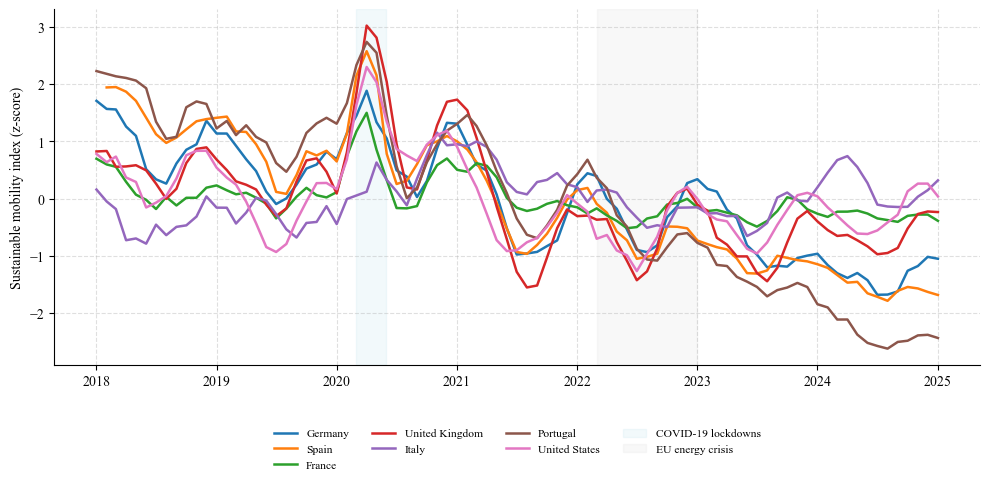

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "font.family": "Times new roman",
    "font.size": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.4,
    "legend.frameon": False
})

# Suponiendo que ya tienes `df_indice` procesado como antes:
df_plot = (
    df_indice
      .sort_values("date")
      .assign(IDMS_smooth=lambda d: d.groupby("country")["indice_normalizado"]
                                      .transform(lambda s: s.rolling(3, center=True, min_periods=1).mean()))
)

# Etiquetas país en orden deseado
country_labels = {
    "DE": "Germany", "FR": "France", "GB": "United Kingdom",
    "IT": "Italy", "PT": "Portugal", "US": "United States", "ES": "Spain"
}

fig, ax = plt.subplots()

for country, g in df_plot.groupby("country"):
    label = country_labels.get(country, country)
    ax.plot(g["date"], g["IDMS_smooth"], label=label, linewidth=1.8)

# Eventos globales
ax.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2020-05-31"),
           alpha=.15, color="lightblue", label="COVID-19 lockdowns")
ax.axvspan(pd.Timestamp("2022-03-01"), pd.Timestamp("2022-12-31"),
           alpha=.15, color="lightgrey", label="EU energy crisis")

# Ejes
ax.set_ylabel("Sustainable mobility index (z-score)")

# Leyenda abajo, centrada
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    fontsize="small"
)

plt.tight_layout()
plt.show()


In [16]:
df_indice['country'].unique()

array(['DE', 'FR', 'GB', 'IT', 'PT', 'US', 'ES'], dtype=object)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\34645\AppData\Local\Temp\ipykernel_4176\3370676903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last["cluster"] = model.labels_


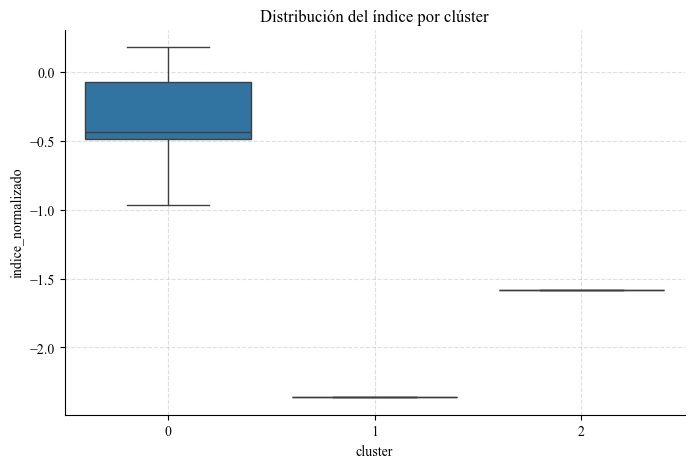

In [17]:
from sklearn.cluster import KMeans

def clustering_preliminar(df_indice, k=3):
    df_last = df_indice[df_indice["date"] == df_indice["date"].max()]
    model = KMeans(n_clusters=k, random_state=0).fit(df_last[["indice_normalizado"]])
    df_last["cluster"] = model.labels_
    return df_last

df_clusters = clustering_preliminar(df_indice)

# Visualizar
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_clusters, x="cluster", y="indice_normalizado")
plt.title("Distribución del índice por clúster")
plt.grid(True)
plt.show()

In [18]:
df_clusters = clustering_preliminar(df_indice, k=3)

# Agrupar por país y clúster asignado
asignacion_clusters = df_clusters[["country", "cluster"]].sort_values("cluster")
print(asignacion_clusters)

    country  cluster
584      DE        0
586      FR        0
587      GB        0
588      IT        0
590      US        0
589      PT        1
585      ES        2


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\34645\AppData\Local\Temp\ipykernel_4176\3370676903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last["cluster"] = model.labels_


In [19]:
print("📌 Asignación de países a clústeres:")
for c in sorted(df_clusters["cluster"].unique()):
    paises = df_clusters[df_clusters["cluster"] == c]["country"].tolist()
    print(f"🔹 Cluster {c}: {', '.join(paises)}")


📌 Asignación de países a clústeres:
🔹 Cluster 0: DE, FR, GB, IT, US
🔹 Cluster 1: PT
🔹 Cluster 2: ES


In [20]:
import pandas as pd

# --- 1. Leer archivos de CPI desde OCDE
path_base = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory"

df_all = pd.read_csv(f"{path_base}\\cpi_all.csv")
df_transport = pd.read_csv(f"{path_base}\\cpi_transport.csv")
df_energy = pd.read_csv(f"{path_base}\\cpi_energy.csv")

# --- 2. Función de limpieza
def limpiar_cpi(df, value_name):
    df = df[["REF_AREA", "TIME_PERIOD", "OBS_VALUE"]].copy()
    df.columns = ["country", "month", value_name]
    df["month"] = pd.to_datetime(df["month"]).dt.to_period("M").astype(str)
    df[value_name] = pd.to_numeric(df[value_name], errors="coerce")
    return df

# --- 3. Limpiar datasets OCDE
df_all = limpiar_cpi(df_all, "cpi_all")
df_transport = limpiar_cpi(df_transport, "cpi_transport")
df_energy = limpiar_cpi(df_energy, "cpi_energy")

# --- 4. Homogeneizar códigos ISO (ISO3 → ISO2)
iso_map = {
    "DEU": "DE", "FRA": "FR", "GBR": "GB",
    "ITA": "IT", "PRT": "PT", "USA": "US", "ESP": "ES"
}

for df in [df_all, df_transport, df_energy]:
    df["country"] = df["country"].map(iso_map)

# --- 5. Cargar CPI energético desde FRED (solo para USA)
df_us_energy = pd.read_csv(f"{path_base}\\cpi_us.csv")

# --- 6. Limpiar CPI energético USA
df_us_energy["month"] = pd.to_datetime(df_us_energy["observation_date"]).dt.to_period("M").astype(str)
df_us_energy["country"] = "US"
df_us_energy = df_us_energy.rename(columns={"CPGREN01USM659N": "cpi_energy"})
df_us_energy = df_us_energy[["country", "month", "cpi_energy"]]

# --- 7. Reemplazar o añadir CPI energético de USA en df_energy
#     Elimina filas anteriores de USA y concatena las nuevas
df_energy = df_energy[df_energy["country"] != "US"]
df_energy = pd.concat([df_energy, df_us_energy], ignore_index=True)

# --- 8. Combinar los tres CPI en un único DataFrame
df_cpi_combined = df_all.merge(df_transport, on=["country", "month"], how="outer")
df_cpi_combined = df_cpi_combined.merge(df_energy, on=["country", "month"], how="outer")

# --- 9. Crear columna 'month' en df_indice si no existe
df_indice["month"] = df_indice["date"].dt.to_period("M").astype(str)

# --- 10. Merge final con el panel
df_model = pd.merge(df_indice, df_cpi_combined, on=["country", "month"], how="left")


In [21]:
# Ruta al archivo original del boletín
file_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\Weekly_Oil_Bulletin_Prices_History.xlsx"

def load_fuel_prices(file_path, countries=['DE', 'FR', 'UK', 'IT', 'PT', 'ES']):
    df = pd.read_excel(file_path, sheet_name="Prices with taxes", header=[0, 1, 2])

    # Detectar la columna de fechas (triple nivel)
    date_col = [col for col in df.columns if isinstance(col, tuple) and 'Date' in col[2]][0]
    df['Date'] = pd.to_datetime(df[date_col], errors='coerce')
    df = df[df['Date'].notna()]

    tidy = []

    for iso2 in countries:
        # Buscar columnas de gasolina y diésel
        petrol_cols = [col for col in df.columns if col[0] == f"{iso2}_price_with_tax_euro95"]
        diesel_cols = [col for col in df.columns if col[0] == f"{iso2}_price_with_tax_diesel"]

        if petrol_cols:
            tmp = pd.DataFrame({
                'country': iso2,
                'date_daily': df['Date'],
                'variable': 'fuel_price_euro95',
                'value': pd.to_numeric(df[petrol_cols[0]], errors='coerce')
            })
            tidy.append(tmp)

        if diesel_cols:
            tmp = pd.DataFrame({
                'country': iso2,
                'date_daily': df['Date'],
                'variable': 'fuel_price_diesel',
                'value': pd.to_numeric(df[diesel_cols[0]], errors='coerce')
            })
            tidy.append(tmp)

    # Unir todos los países
    fuel_long = pd.concat(tidy, ignore_index=True)
    fuel_long['value'] = fuel_long['value'] / 1000  # €/1000L → €/L
    fuel_long['date'] = fuel_long['date_daily'].dt.to_period('M')

    # Agregar promedio mensual por país y tipo
    fuel_month = (
        fuel_long
        .groupby(['country', 'date', 'variable'], as_index=False)['value']
        .mean()
    )

    # Normalizar códigos país: UK → GB
    fuel_month['country'] = fuel_month['country'].replace({'UK': 'GB'})

    # Filtrar ventana del panel
    fuel_month = fuel_month[
        (fuel_month['date'] >= '2018-01') & (fuel_month['date'] <= '2025-03')
    ]

    return fuel_month

# Ejecutar función con 'UK' y luego mapear a 'GB'
fuel_df = load_fuel_prices(file_path)

# Pivotear a formato ancho
fuel_wide = (
    fuel_df.pivot(index=['country', 'date'], columns='variable', values='value')
           .reset_index()
)

# Asegurar tipo Period[M] para merge
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

# Merge con el panel principal
df_model = df_model.merge(fuel_wide, how='left', on=['country', 'date'])

# Vista rápida
df_model[df_model['country'] == 'GB'][['date', 'fuel_price_diesel', 'fuel_price_euro95']].dropna().head()



C:\Users\34645\AppData\Local\Temp\ipykernel_4176\2540306633.py:69: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


,date,fuel_price_diesel,fuel_price_euro95
2,2018-01,1.407658,1.367884
9,2018-02,1.407462,1.367095
15,2018-03,1.394727,1.352677
22,2018-04,1.429962,1.386757
29,2018-05,1.471450,1.426235


In [23]:
# Ruta a tus archivos locales
path_gas = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\GASREGW.csv"
path_diesel = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\GASDESW.csv"

# 1. Leer archivos semanales
df_gas = pd.read_csv(path_gas, parse_dates=['observation_date'])
df_diesel = pd.read_csv(path_diesel, parse_dates=['observation_date'])

# 2. Definir parámetros de conversión
GALLON_TO_LITRE = 3.78541
eurusd = 0.92  # tipo de cambio USD→EUR, ajustalo con valor real si querés mayor precisión

# 3. Procesar gasolina (GASREGW)
df_gas['value'] = (df_gas['GASREGW'] / GALLON_TO_LITRE) * eurusd
df_gas['country'] = 'US'
df_gas['variable'] = 'fuel_price_euro95'
df_gas['date'] = df_gas['observation_date'].dt.to_period('M')

# 4. Procesar diésel (GASDESW)
df_diesel['value'] = (df_diesel['GASDESW'] / GALLON_TO_LITRE) * eurusd
df_diesel['country'] = 'US'
df_diesel['variable'] = 'fuel_price_diesel'
df_diesel['date'] = df_diesel['observation_date'].dt.to_period('M')

# 5. Agregar por mes
df_gas_month = df_gas.groupby(['country', 'date', 'variable'])['value'].mean().reset_index()
df_diesel_month = df_diesel.groupby(['country', 'date', 'variable'])['value'].mean().reset_index()

# 6. Unir y pivotear
fuel_us = pd.concat([df_gas_month, df_diesel_month], ignore_index=True)

fuel_us_wide = (
    fuel_us.pivot(index=['country', 'date'], columns='variable', values='value')
           .reset_index()
)

# 🔧 Asegurar que columnas sean planas
fuel_us_wide.columns.name = None
fuel_us_wide.columns = [str(col) for col in fuel_us_wide.columns]

# 7. Asegurar que date sea Period[M]
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

# 8. Merge
df_model = df_model.merge(fuel_us_wide, how='left', on=['country', 'date'])

# ✅ Verificación: mostrar US con precios
df_model[df_model['country'] == 'US'][['date', 'fuel_price_diesel', 'fuel_price_euro95']].dropna().head()


C:\Users\34645\AppData\Local\Temp\ipykernel_4176\1144494342.py:42: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


,date,fuel_price_diesel,fuel_price_euro95
5,2018-01,0.733587,0.620866
11,2018-02,0.740234,0.628801
18,2018-03,0.726077,0.629773
25,2018-04,0.752398,0.670057
32,2018-05,0.788356,0.704994


In [24]:
df_model['fuel_price_diesel'] = df_model['fuel_price_diesel_x'].combine_first(df_model['fuel_price_diesel'])
df_model['fuel_price_euro95'] = df_model['fuel_price_euro95_x'].combine_first(df_model['fuel_price_euro95'])

df_model.drop(columns=[
    'fuel_price_diesel_x', 'fuel_price_diesel_y',
    'fuel_price_euro95_x', 'fuel_price_euro95_y'
], inplace=True)


In [25]:

# 1. Leer el archivo Excel
ev_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\EV_panel.xlsx"
df_ev = pd.read_excel(ev_path)

# 2. Asegurar formato de fecha y país
df_ev['date'] = pd.to_datetime(df_ev['date']).dt.to_period('M')
df_ev['country'] = df_ev['country'].str.upper()

# 3. Calcular total de registros EV (BEV + PHEV)
df_ev['ev_sales_total'] = df_ev['BEV'] + df_ev['PHEV']

# 4. Seleccionar columnas útiles
df_ev_clean = df_ev[['country', 'date', 'ev_sales_total']]

# 5. Merge con df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_ev_clean, how='left', on=['country', 'date'])

# 6. Vista rápida para verificar
df_model[df_model['country'] == 'FR'][['date', 'ev_sales_total']].dropna().head()

C:\Users\34645\AppData\Local\Temp\ipykernel_4176\25625894.py:16: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


,date,ev_sales_total
1,2018-01,2331.0
8,2018-02,3138.0
14,2018-03,5411.0
21,2018-04,2833.0
28,2018-05,3098.0


In [27]:
# 1. Leer el archivo de ventas EV USA
path_ev_us = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\ev_sales_US_2018_2025.csv"  # o usa el path en /mnt/data si lo descargaste aquí
df_ev_us = pd.read_csv(path_ev_us)

# 2. Asegurar formato
df_ev_us['date'] = pd.to_datetime(df_ev_us['date']).dt.to_period('M')
df_ev_us['country'] = 'US'  # por si viene en minúscula

# 3. Merge con df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_ev_us, how='left', on=['country', 'date'])

# 4. Verificar integración
df_model[df_model['country'] == 'US'][['date', 'ev_sales_total']].dropna().head()


C:\Users\34645\AppData\Local\Temp\ipykernel_4176\2604569783.py:10: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


,date,ev_sales_total
5,2018-01,15395.0
11,2018-02,15436.0
18,2018-03,22661.0
25,2018-04,22725.0
32,2018-05,23635.0


In [28]:
# 1. Combinar las columnas: tomar primero la europea, luego US si falta
df_model['ev_sales_total'] = df_model['ev_sales_total_x'].combine_first(df_model['ev_sales_total_y'])

# 2. Eliminar columnas intermedias duplicadas
df_model.drop(columns=['ev_sales_total_x', 'ev_sales_total_y'], inplace=True)

# 3. Verificar resultado
df_model[df_model['ev_sales_total'].notna()][['country', 'date', 'ev_sales_total']].head()


,country,date,ev_sales_total
0,DE,2018-01,5612.0
1,FR,2018-01,2331.0
2,GB,2018-01,3284.0
3,IT,2018-01,574.0
4,PT,2018-01,482.0


In [29]:
# Ruta al CSV
csv_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\Global_Mobility_Report.csv"
countries_iso2 = ['DE', 'FR', 'GB', 'IT', 'PT', 'US', 'ES']

# Columnas de interés
usecols = [
    'country_region_code', 'date',
    'workplaces_percent_change_from_baseline',
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline'
]

# Leer por chunks
chunks = []
for chunk in pd.read_csv(csv_path, usecols=usecols, parse_dates=['date'], chunksize=200_000):
    chunk = chunk[chunk['country_region_code'].isin(countries_iso2)]
    chunks.append(chunk)

df_mob = pd.concat(chunks, ignore_index=True)

# Renombrar
df_mob.rename(columns={
    'country_region_code': 'country',
    'workplaces_percent_change_from_baseline': 'workplace_mobility',
    'retail_and_recreation_percent_change_from_baseline': 'retail_mobility',
    'grocery_and_pharmacy_percent_change_from_baseline': 'grocery_mobility',
    'transit_stations_percent_change_from_baseline': 'transit_mobility'
}, inplace=True)

# Formato
df_mob['country'] = df_mob['country'].str.upper()
df_mob['date'] = df_mob['date'].dt.to_period('M')

# Promedio mensual por país
df_mob_month = (
    df_mob.groupby(['country', 'date'], as_index=False)[[
        'workplace_mobility',
        'retail_mobility',
        'grocery_mobility',
        'transit_mobility'
    ]].mean()
)

# Merge con df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_mob_month, how='left', on=['country', 'date'])

# Opcional: imputar baseline 0 pre-2020
for col in ['workplace_mobility', 'retail_mobility', 'grocery_mobility', 'transit_mobility']:
    df_model[col] = df_model[col].fillna(0)

# Vista rápida
df_model[df_model['country'] == 'DE'][['date', 'workplace_mobility', 'retail_mobility', 'transit_mobility']].head()


C:\Users\34645\AppData\Local\Temp\ipykernel_4176\1567505721.py:46: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


,date,workplace_mobility,retail_mobility,transit_mobility
0,2018-01,0.0,0.0,0.0
6,2018-02,0.0,0.0,0.0
12,2018-03,0.0,0.0,0.0
19,2018-04,0.0,0.0,0.0
26,2018-05,0.0,0.0,0.0


In [30]:
import pandas as pd
import glob
import os

# 1. Ruta local a la carpeta con los archivos OECD
folder = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory"
pattern = os.path.join(folder, "LRHUTTTT*.csv")

# 2. Mapeo ISO2 (porque los archivos terminan en IT, DE, etc.)
iso_code_map = {
    'DE': 'DE',
    'ES': 'ES',
    'FR': 'FR',
    'GB': 'GB',
    'IT': 'IT',
    'PT': 'PT',
    'US': 'US'
}

# 3. Leer y preparar todos los archivos
dfs = []

for filepath in glob.glob(pattern):
    filename = os.path.basename(filepath)
    iso2 = filename.replace("LRHUTTTT", "").replace("M156S.csv", "")
    
    print(f"Procesando archivo: {filename} | ISO2 detectado: {iso2}")

    if iso2 in iso_code_map:
        try:
            df = pd.read_csv(filepath)
            # Renombrar columnas dinámicamente
            date_col, value_col = df.columns[:2]
            df = df.rename(columns={
                date_col: 'date',
                value_col: 'unemployment_rate'
            })
            df['date'] = pd.to_datetime(df['date']).dt.to_period('M')
            df['country'] = iso_code_map[iso2]
            dfs.append(df[['country', 'date', 'unemployment_rate']])
        except Exception as e:
            print(f"⚠️ Error procesando {filename}: {e}")

# 4. Concatenar todos los países
if dfs:
    df_unemp = pd.concat(dfs, ignore_index=True)

    # 5. Asegurar Period[M] en df_model
    if not pd.api.types.is_period_dtype(df_model['date']):
        df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

    # 6. Merge por país y mes
    df_model = df_model.merge(df_unemp, how='left', on=['country', 'date'])

    # 7. Vista rápida
    print("✅ Integración completa. Ejemplo para IT:")
    print(df_model[df_model['country'] == 'IT'][['date', 'unemployment_rate']].dropna().head())

else:
    print("🚫 No se cargó ningún archivo. Verificá nombres y extensión .csv")


Procesando archivo: LRHUTTTTDEM156S.csv | ISO2 detectado: DE
Procesando archivo: LRHUTTTTESM156S.csv | ISO2 detectado: ES
Procesando archivo: LRHUTTTTFRM156S.csv | ISO2 detectado: FR
Procesando archivo: LRHUTTTTGBM156S.csv | ISO2 detectado: GB
Procesando archivo: LRHUTTTTITM156S.csv | ISO2 detectado: IT
Procesando archivo: LRHUTTTTPTM156S.csv | ISO2 detectado: PT
Procesando archivo: LRHUTTTTUSM156S.csv | ISO2 detectado: US
✅ Integración completa. Ejemplo para IT:
       date  unemployment_rate
3   2018-01               11.0
10  2018-02               10.8
16  2018-03               10.9
23  2018-04               11.0
30  2018-05               10.6


C:\Users\34645\AppData\Local\Temp\ipykernel_4176\287687234.py:49: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


In [31]:
df_model

,date,country,movilidad_sostenible,indice_normalizado,month,cpi_all,cpi_transport,cpi_energy,fuel_price_diesel,fuel_price_euro95,ev_sales_total,workplace_mobility,retail_mobility,grocery_mobility,transit_mobility,unemployment_rate
0,2018-01,DE,1.354521,1.437988,2018-01,1.5,1.5,0.700000,1.199600,1.366600,5612.0,0.0,0.0,0.0,0.0,3.3
1,2018-01,FR,0.434826,0.461620,2018-01,2.6,1.5,5.100000,1.374224,1.461024,2331.0,0.0,0.0,0.0,0.0,9.2
2,2018-01,GB,1.108565,1.176877,2018-01,3.4,3.0,4.300000,1.407658,1.367884,3284.0,0.0,0.0,0.0,0.0,4.2
3,2018-01,IT,-0.273292,-0.290132,2018-01,1.6,1.2,4.600000,1.439560,1.565374,574.0,0.0,0.0,0.0,0.0,11.0
4,2018-01,PT,2.352625,2.497597,2018-01,3.3,1.1,2.300000,1.328000,1.520200,482.0,0.0,0.0,0.0,0.0,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,2025-01,FR,-0.461866,-0.490326,2025-01,1.0,1.8,2.600000,1.699970,1.802305,24777.0,0.0,0.0,0.0,0.0,7.3
587,2025-01,GB,-0.412001,-0.437389,2025-01,1.7,3.0,-6.600000,NaN,NaN,42318.0,0.0,0.0,0.0,0.0,NaN
588,2025-01,IT,0.167060,0.177355,2025-01,1.0,1.7,-0.700000,1.707667,1.805000,11579.0,0.0,0.0,0.0,0.0,6.2
589,2025-01,PT,-2.223725,-2.360755,2025-01,2.2,2.7,2.700000,1.657250,1.760500,5217.0,0.0,0.0,0.0,0.0,6.3


In [ ]:
# 1. Leer tipo de cambio diario
fx_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\DEXUSEU.csv"
df_fx = pd.read_csv(fx_path)

# 2. Convertir a Period[M] y calcular promedio mensual
df_fx.rename(columns={'observation_date': 'date', 'DEXUSEU': 'exchange_rate_usdeur'}, inplace=True)
df_fx['date'] = pd.to_datetime(df_fx['date']).dt.to_period('M')
df_fx_month = df_fx.groupby('date', as_index=False)['exchange_rate_usdeur'].mean()

# 3. Merge directo con todos los países
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_fx_month, how='left', on='date')

# Verificar
df_model[['country', 'date', 'exchange_rate_usdeur']].dropna().head()



C:\Users\34645\AppData\Local\Temp\ipykernel_19832\970010928.py:11: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


,country,date,exchange_rate_usdeur
0,DE,2018-01,1.219652
1,FR,2018-01,1.219652
2,GB,2018-01,1.219652
3,IT,2018-01,1.219652
4,PT,2018-01,1.219652


In [32]:
# 1. Ruta local del archivo
file_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory\OECD.SDD.STES,DSD_STES@DF_CLI,+PRT+USA+GBR+ESP+ITA+DEU+FRA.M.CCICP...AA...H.csv"

# 2. Leer el CSV completo
df_cci = pd.read_csv(file_path)

# 3. Filtrar solo filas con observaciones (fila empieza con "DATAFLOW")
df_cci = df_cci[df_cci['STRUCTURE'] == 'DATAFLOW']

# 4. Seleccionar columnas clave
df_cci_clean = df_cci[['REF_AREA', 'TIME_PERIOD', 'OBS_VALUE']].copy()
df_cci_clean.columns = ['country', 'date', 'consumer_confidence_index']

# 5. Convertir fecha y tipo
df_cci_clean['date'] = pd.to_datetime(df_cci_clean['date']).dt.to_period('M')
df_cci_clean['consumer_confidence_index'] = pd.to_numeric(df_cci_clean['consumer_confidence_index'], errors='coerce')

# 6. Convertir código ISO3 → ISO2
iso3_to_iso2 = {
    'DEU': 'DE',
    'FRA': 'FR',
    'ITA': 'IT',
    'PRT': 'PT',
    'ESP': 'ES',
    'GBR': 'GB',
    'USA': 'US'
}
df_cci_clean['country'] = df_cci_clean['country'].map(iso3_to_iso2)

# 7. Merge con tu df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_cci_clean, how='left', on=['country', 'date'])

# 8. Verificación rápida
df_model[df_model['country'] == 'PT'][['date', 'consumer_confidence_index']].dropna().head()

C:\Users\34645\AppData\Local\Temp\ipykernel_4176\3985214736.py:31: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


,date,consumer_confidence_index
4,2018-01,102.0789
17,2018-03,102.1752
24,2018-04,102.1641
31,2018-05,102.0984
38,2018-06,101.9692


In [33]:
df_model

,date,country,movilidad_sostenible,indice_normalizado,month,cpi_all,cpi_transport,cpi_energy,fuel_price_diesel,fuel_price_euro95,ev_sales_total,workplace_mobility,retail_mobility,grocery_mobility,transit_mobility,unemployment_rate,consumer_confidence_index
0,2018-01,DE,1.354521,1.437988,2018-01,1.5,1.5,0.700000,1.199600,1.366600,5612.0,0.0,0.0,0.0,0.0,3.3,102.03790
1,2018-01,FR,0.434826,0.461620,2018-01,2.6,1.5,5.100000,1.374224,1.461024,2331.0,0.0,0.0,0.0,0.0,9.2,101.09800
2,2018-01,GB,1.108565,1.176877,2018-01,3.4,3.0,4.300000,1.407658,1.367884,3284.0,0.0,0.0,0.0,0.0,4.2,100.66040
3,2018-01,IT,-0.273292,-0.290132,2018-01,1.6,1.2,4.600000,1.439560,1.565374,574.0,0.0,0.0,0.0,0.0,11.0,101.37390
4,2018-01,PT,2.352625,2.497597,2018-01,3.3,1.1,2.300000,1.328000,1.520200,482.0,0.0,0.0,0.0,0.0,7.9,102.07890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,2025-01,FR,-0.461866,-0.490326,2025-01,1.0,1.8,2.600000,1.699970,1.802305,24777.0,0.0,0.0,0.0,0.0,7.3,98.47190
587,2025-01,GB,-0.412001,-0.437389,2025-01,1.7,3.0,-6.600000,NaN,NaN,42318.0,0.0,0.0,0.0,0.0,NaN,98.91624
588,2025-01,IT,0.167060,0.177355,2025-01,1.0,1.7,-0.700000,1.707667,1.805000,11579.0,0.0,0.0,0.0,0.0,6.2,100.02980
589,2025-01,PT,-2.223725,-2.360755,2025-01,2.2,2.7,2.700000,1.657250,1.760500,5217.0,0.0,0.0,0.0,0.0,6.3,99.89841


In [34]:
# 1. Ruta a la carpeta con los archivos
base_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory"

# 2. Mapeo nombre archivo → ISO2
country_files = {
    'italy.csv': 'IT',
    'spain.csv': 'ES',
    'france.csv': 'FR',
    'portugal.csv': 'PT',
    'germany.csv': 'DE',
    'united-kingdom.csv': 'GB',
    'united-states.csv': 'US'
}

# 3. Lista para almacenar resultados
dfs = []

# 4. Leer e integrar cada archivo
for file_name, iso2 in country_files.items():
    file_path = os.path.join(base_path, file_name)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, comment='#')  # ignora líneas con "#"
        df['country'] = iso2
        df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=15)).dt.to_period('M')
        df.rename(columns={'temperature_C': 'temperature_mean'}, inplace=True)
        dfs.append(df[['country', 'date', 'temperature_mean']])
    else:
        print(f"Archivo no encontrado: {file_name}")

# 5. Concatenar todo
df_temp = pd.concat(dfs, ignore_index=True)

# 6. Filtrar periodo de interés
df_temp = df_temp[(df_temp['date'] >= '2018-01') & (df_temp['date'] <= '2025-03')]

# 7. Unir con df_model
if not pd.api.types.is_period_dtype(df_model['date']):
    df_model['date'] = pd.to_datetime(df_model['date']).dt.to_period('M')

df_model = df_model.merge(df_temp, how='left', on=['country', 'date'])


C:\Users\34645\AppData\Local\Temp\ipykernel_4176\3221129068.py:37: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df_model['date']):


In [35]:
df_model

,date,country,movilidad_sostenible,indice_normalizado,month,cpi_all,cpi_transport,cpi_energy,fuel_price_diesel,fuel_price_euro95,ev_sales_total,workplace_mobility,retail_mobility,grocery_mobility,transit_mobility,unemployment_rate,consumer_confidence_index,temperature_mean
0,2018-01,DE,1.354521,1.437988,2018-01,1.5,1.5,0.700000,1.199600,1.366600,5612.0,0.0,0.0,0.0,0.0,3.3,102.03790,12.423
1,2018-01,FR,0.434826,0.461620,2018-01,2.6,1.5,5.100000,1.374224,1.461024,2331.0,0.0,0.0,0.0,0.0,9.2,101.09800,14.397
2,2018-01,GB,1.108565,1.176877,2018-01,3.4,3.0,4.300000,1.407658,1.367884,3284.0,0.0,0.0,0.0,0.0,4.2,100.66040,10.009
3,2018-01,IT,-0.273292,-0.290132,2018-01,1.6,1.2,4.600000,1.439560,1.565374,574.0,0.0,0.0,0.0,0.0,11.0,101.37390,15.564
4,2018-01,PT,2.352625,2.497597,2018-01,3.3,1.1,2.300000,1.328000,1.520200,482.0,0.0,0.0,0.0,0.0,7.9,102.07890,15.233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,2025-01,FR,-0.461866,-0.490326,2025-01,1.0,1.8,2.600000,1.699970,1.802305,24777.0,0.0,0.0,0.0,0.0,7.3,98.47190,NaN
587,2025-01,GB,-0.412001,-0.437389,2025-01,1.7,3.0,-6.600000,NaN,NaN,42318.0,0.0,0.0,0.0,0.0,NaN,98.91624,NaN
588,2025-01,IT,0.167060,0.177355,2025-01,1.0,1.7,-0.700000,1.707667,1.805000,11579.0,0.0,0.0,0.0,0.0,6.2,100.02980,NaN
589,2025-01,PT,-2.223725,-2.360755,2025-01,2.2,2.7,2.700000,1.657250,1.760500,5217.0,0.0,0.0,0.0,0.0,6.3,99.89841,NaN


In [51]:
# Ruta base donde tienes los archivos
base_path = r"C:\Users\34645\Desktop\projects\GoogleTrends\Data\raw_explanatory"

# Lista de archivos por país
archivos = {
    'PT': 'charging_points_PT.csv',
    'ES': 'charging_points_ES.csv',
    'GB': 'charging_points_GB.csv',
    'FR': 'charging_points_FR.csv',
    'DE': 'charging_points_DE.csv',
    'IT': 'charging_points_IT.csv',
}

# Función para convertir '2020 Q1' en '2020-01-01'
def quarter_to_date(qstr):
    year, quarter = qstr.split(' Q')
    month = {'1': '01', '2': '04', '3': '07', '4': '10'}[quarter]
    return pd.to_datetime(f"{year}-{month}-01")

# Leer, procesar y concatenar todos los archivos
df_list = []
for pais, archivo in archivos.items():
    df = pd.read_csv(os.path.join(base_path, archivo))
    df['country'] = pais
    df['date'] = df['Category'].apply(quarter_to_date)
    df['charging_total'] = df['AC'] + df['DC']
    df_list.append(df[['country', 'date', 'charging_total']])

# DataFrame combinado
df_chargers = pd.concat(df_list).sort_values(['country', 'date']).reset_index(drop=True)

# Interpolación mensual
df_monthly = (
    df_chargers
    .set_index('date')
    .groupby('country')['charging_total']
    .resample('M')
    .interpolate('linear')
    .reset_index()
)

# Asegurar que 'date' en df_model es datetime
df_model['date'] = pd.to_datetime(df_model['date'])
df_monthly['date'] = pd.to_datetime(df_monthly['date'])


# Integrar al modelo
df_model = df_model.merge(df_monthly, on=['country', 'date'], how='left')



C:\Users\34645\AppData\Local\Temp\ipykernel_4176\996319655.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


In [53]:
df_model

,date,country,movilidad_sostenible,indice_normalizado,month,cpi_all,cpi_transport,cpi_energy,fuel_price_diesel,fuel_price_euro95,...,workplace_mobility,retail_mobility,grocery_mobility,transit_mobility,unemployment_rate,consumer_confidence_index,temperature_mean,charging_total_x,charging_total_y,charging_total
0,2018-01-01,DE,1.354521,1.437988,2018-01,1.5,1.5,0.700000,1.199600,1.366600,...,0.0,0.0,0.0,0.0,3.3,102.03790,12.423,NaN,NaN,NaN
1,2018-01-01,FR,0.434826,0.461620,2018-01,2.6,1.5,5.100000,1.374224,1.461024,...,0.0,0.0,0.0,0.0,9.2,101.09800,14.397,NaN,NaN,NaN
2,2018-01-01,GB,1.108565,1.176877,2018-01,3.4,3.0,4.300000,1.407658,1.367884,...,0.0,0.0,0.0,0.0,4.2,100.66040,10.009,NaN,NaN,NaN
3,2018-01-01,IT,-0.273292,-0.290132,2018-01,1.6,1.2,4.600000,1.439560,1.565374,...,0.0,0.0,0.0,0.0,11.0,101.37390,15.564,NaN,NaN,NaN
4,2018-01-01,PT,2.352625,2.497597,2018-01,3.3,1.1,2.300000,1.328000,1.520200,...,0.0,0.0,0.0,0.0,7.9,102.07890,15.233,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,2025-01-01,FR,-0.461866,-0.490326,2025-01,1.0,1.8,2.600000,1.699970,1.802305,...,0.0,0.0,0.0,0.0,7.3,98.47190,NaN,NaN,NaN,NaN
587,2025-01-01,GB,-0.412001,-0.437389,2025-01,1.7,3.0,-6.600000,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,98.91624,NaN,NaN,NaN,NaN
588,2025-01-01,IT,0.167060,0.177355,2025-01,1.0,1.7,-0.700000,1.707667,1.805000,...,0.0,0.0,0.0,0.0,6.2,100.02980,NaN,NaN,NaN,NaN
589,2025-01-01,PT,-2.223725,-2.360755,2025-01,2.2,2.7,2.700000,1.657250,1.760500,...,0.0,0.0,0.0,0.0,6.3,99.89841,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Asegúrate de tener las fechas en datetime y país como categoría
df_model['month'] = pd.to_datetime(df_model['month'])
df_model['year'] = df_model['month'].dt.year
df_model['country'] = df_model['country'].astype('category')

# Fórmula del modelo
formula = (
    "indice_normalizado ~ cpi_all + cpi_transport + cpi_energy + "
    "fuel_price_diesel + fuel_price_euro95 + ev_sales_total + "
    "workplace_mobility + transit_mobility + unemployment_rate + "
    "exchange_rate_usdeur + consumer_confidence_index + temperature_mean_x + "
    "C(country) + C(year)"
)


# Ajustar el modelo de regresión lineal con efectos fijos
model = smf.ols(formula=formula, data=df_model).fit(cov_type='HC3')  # robusto a heterocedasticidad

# Resumen de resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     indice_normalizado   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     26.86
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           5.19e-44
Time:                        17:07:01   Log-Likelihood:                -144.96
No. Observations:                 212   AIC:                             329.9
Df Residuals:                     192   BIC:                             397.1
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 19
  warnings.warn('covariance of constraints does not have full '
